In [1]:
# IN jupyter, shift+r will change output bar to the right side of the code bar, care.
# Use capslock to type captial letter "R"!!!!

# based on fine-tuned pre-trained ResNet50
Loading pretrained model 


In [2]:
import os,gc,time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV3Small, ResNet50
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten
from tensorflow.keras.backend import clear_session

RANDOM_SEED = 2023 # random seed for k-fold cross-validation
BATCH_SIZE = 16  
EPOCH_NUM = 50
FOLD_NUM = 5
num_channels = 3 # number of channels = 3: RGB
image_size = (224, 224) # set image size

# early stop metrics monitoring validation loss, in order to compare models, set all epoch=50 fixed, not used now.
#early_stopping_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#early_stopping_accuracy = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#CALLBACKS = [early_stopping_loss, early_stopping_accuracy]

# set CUDA environment variables
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # use GPU0
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # reduce potential conflict of packages
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true" # GPU memory management

# set data dir
data_dir = "./data/merged_aug_data_224"
#train_dir = "./data/aug_data_224/Train"
#test_dir = "./data/aug_data_224/Test"

# set folder address, avoid duplicated directory name
model_weights_dir = './models/ResNet'
model_id = 0
while os.path.exists(model_weights_dir):
    model_id += 1
    model_weights_dir = f'./models/ResNet{model_id}/'
if not os.path.exists(model_weights_dir):
    os.makedirs(model_weights_dir)

# save all configurations in a txt file
with open(os.path.join(model_weights_dir, 'info.txt'), 'w') as file:
    variables = {
        'RANDOM_SEED': RANDOM_SEED,
        'BATCH_SIZE': BATCH_SIZE,
        'EPOCH_NUM': EPOCH_NUM,
        'FOLD_NUM': FOLD_NUM,
        'num_channels': num_channels,
        'image_size': image_size,
        #'monitor of early_stopping_loss':early_stopping_loss.monitor,
        #'patience of early_stopping_loss':early_stopping_loss.patience,
        #'restore_best_weights of early_stopping_loss':early_stopping_loss.restore_best_weights,
        #'monitor of early_stopping_accuracy': early_stopping_loss.monitor,
        #'patience of early_stopping_accuracy': early_stopping_loss.patience,
        #'restore_best_weights of early_stopping_accuracy': early_stopping_loss.restore_best_weights,
        'CUDA_VISIBLE_DEVICES': os.environ["CUDA_VISIBLE_DEVICES"],
        'KMP_DUPLICATE_LIB_OK': os.environ["KMP_DUPLICATE_LIB_OK"],
        'TF_FORCE_GPU_ALLOW_GROWTH': os.environ['TF_FORCE_GPU_ALLOW_GROWTH'],
        'data_dir:' : data_dir
        #'train_dir': train_dir,
        #'test_dir': test_dir
    }
    for variable, value in variables.items():
        file.write(f'{variable} = {value}\n')
print('Model weights have been saved at：', model_weights_dir)

C:\DevTools\Anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Model weights have been saved at： ./models/ResNet1/


# Design the model

In [3]:
def create_model(input_shape, num_classes):
    # Create a Sequential model
    model = Sequential()

    # Add a normalization layer to preprocess input data
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
    
    # Load MobileNetV3Small model (excluding top classification layers)
    res_net = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in res_net.layers:
        if layer.name.startswith('conv4') or layer.name.startswith('conv5'):
            layer.trainable = True
        else:
            layer.trainable = False
    
    # Add a Global Average Pooling layer to reduce spatial dimensions
    f = GlobalAveragePooling2D()(res_net.output)

    #f = Flatten()(vgg_model.output)
    # Add a Dense layer for classification with softmax activation
    predictions = Dense(num_classes, activation='softmax')(f)
    
    # Compile the model
    model = Model(inputs=res_net.input, outputs=predictions)
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
model_t = create_model((224,224,3), 3)
model_t.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Loading datasets

In [4]:
#Load training set and test set, and their labels
def load_images_and_labels(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        print(f'loading images from {class_dir}')
        for filename in tqdm(os.listdir(class_dir)):
            image_path = os.path.join(class_dir, filename)
            try:
                image = cv2.imread(image_path)
                #image = tf.cast(image, tf.float16) / 255.0 # normalize, out of memeory
                #image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(class_names.index(class_name))
            except Exception as e:
                print(f"Error loading image: {image_path}")
                print(f"Error message: {e}")
    return np.array(images), np.array(labels)

In [5]:
# Get training set and test set, and their label
images, labels = load_images_and_labels(data_dir)

loading images from ./data/merged_aug_data_224\Mild


100%|██████████████████████████████████████████████████████████████████████████| 11200/11200 [00:10<00:00, 1097.11it/s]


loading images from ./data/merged_aug_data_224\Moderate


100%|██████████████████████████████████████████████████████████████████████████| 16372/16372 [00:12<00:00, 1291.39it/s]


loading images from ./data/merged_aug_data_224\Non


100%|██████████████████████████████████████████████████████████████████████████| 12800/12800 [00:08<00:00, 1439.81it/s]


# Training the model with 5-fold cross-validation

Use StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=RANDOM_SEED) to split training set into 5 folds.

    

In [6]:
def get_checkpoint_for_fold(model_id):
    '''
    return checkpoint for each fold of cross-validation
    select the model with the lowest validation loss
    '''
    checkpoint = ModelCheckpoint(model_weights_dir + f'/best_model_{model_id}.h5', 
                                 monitor='val_loss',
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='min',
                                 verbose=2)
    return checkpoint

In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
def test_model(model, test_images, test_labels):
    # use data in test set to make predictions
    test_probabilities = model.predict(test_images)
    test_predictions = np.argmax(test_probabilities, axis=1)

    # calculate metrics
    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    confusion_mat = confusion_matrix(test_labels, test_predictions)
    weighted_auc_ovr = roc_auc_score(test_labels, test_probabilities, average='weighted',multi_class='ovr')
    #print(weighted_auc_ovr)
    weighted_auc_ovo = roc_auc_score(test_labels, test_probabilities, average='weighted',multi_class='ovo')
    #print(weighted_auc_ovo)
    print(f'Test set performance:')
    print("Weighted AUC(OvR):", weighted_auc_ovr)
    print("Weighted AUC(OvO):", weighted_auc_ovo)
    print(f'Weighted F1 score = {f1}')
    print(f'Weighted Precision = {precision}, Weighted Recall = {recall}, Accuracy = {accuracy}')
    print('Confusion matrix:\n')
    print(confusion_mat)

    # get the result of classification report
    report = classification_report(test_labels, test_predictions)
    print(f'Result of classification report:\n')
    print(report)
    return f1, weighted_auc_ovr, weighted_auc_ovo

training on fold 0:
Epoch 1/50
1615/1615 [==============================] - 187s 111ms/step - loss: 0.6987 - accuracy: 0.6843 - val_loss: 0.6003 - val_accuracy: 0.7464

Epoch 00001: val_loss improved from inf to 0.60034, saving model to ./models/ResNet1\best_model_0.h5


C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1615/1615 [==============================] - 176s 109ms/step - loss: 0.4273 - accuracy: 0.8180 - val_loss: 0.3918 - val_accuracy: 0.8387

Epoch 00002: val_loss improved from 0.60034 to 0.39181, saving model to ./models/ResNet1\best_model_0.h5
Epoch 3/50
1615/1615 [==============================] - 171s 106ms/step - loss: 0.2427 - accuracy: 0.9038 - val_loss: 0.3341 - val_accuracy: 0.8687

Epoch 00003: val_loss improved from 0.39181 to 0.33407, saving model to ./models/ResNet1\best_model_0.h5
Epoch 4/50
1615/1615 [==============================] - 169s 105ms/step - loss: 0.1444 - accuracy: 0.9454 - val_loss: 0.3086 - val_accuracy: 0.8884

Epoch 00004: val_loss improved from 0.33407 to 0.30864, saving model to ./models/ResNet1\best_model_0.h5
Epoch 5/50
1615/1615 [==============================] - 170s 105ms/step - loss: 0.0957 - accuracy: 0.9638 - val_loss: 0.5786 - val_accuracy: 0.8262

Epoch 00005: val_loss did not improve from 0.30864
Epoch 6/50
1615/1615 [================

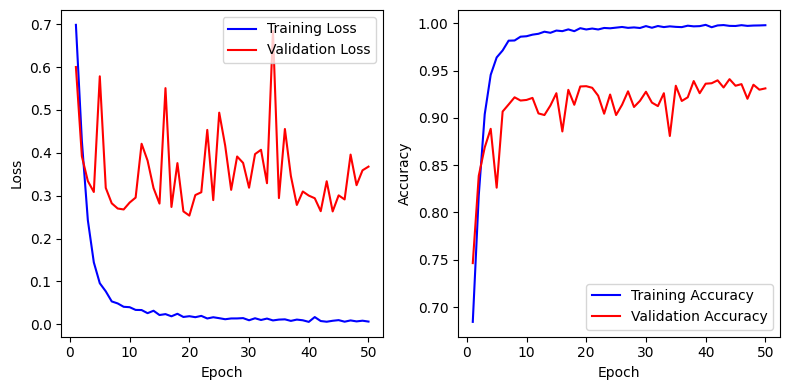

training on fold 1:
Epoch 1/50
1615/1615 [==============================] - 171s 104ms/step - loss: 0.7008 - accuracy: 0.6868 - val_loss: 2.2620 - val_accuracy: 0.4862

Epoch 00001: val_loss improved from inf to 2.26195, saving model to ./models/ResNet1\best_model_1.h5


C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1615/1615 [==============================] - 168s 104ms/step - loss: 0.4688 - accuracy: 0.8028 - val_loss: 0.4894 - val_accuracy: 0.8133

Epoch 00002: val_loss improved from 2.26195 to 0.48937, saving model to ./models/ResNet1\best_model_1.h5
Epoch 3/50
1615/1615 [==============================] - 168s 104ms/step - loss: 0.2883 - accuracy: 0.8858 - val_loss: 0.4017 - val_accuracy: 0.8458

Epoch 00003: val_loss improved from 0.48937 to 0.40166, saving model to ./models/ResNet1\best_model_1.h5
Epoch 4/50
1615/1615 [==============================] - 167s 104ms/step - loss: 0.1667 - accuracy: 0.9361 - val_loss: 0.2893 - val_accuracy: 0.8929

Epoch 00004: val_loss improved from 0.40166 to 0.28930, saving model to ./models/ResNet1\best_model_1.h5
Epoch 5/50
1615/1615 [==============================] - 168s 104ms/step - loss: 0.1056 - accuracy: 0.9599 - val_loss: 0.2616 - val_accuracy: 0.9125

Epoch 00005: val_loss improved from 0.28930 to 0.26157, saving model to ./models/ResNet1\

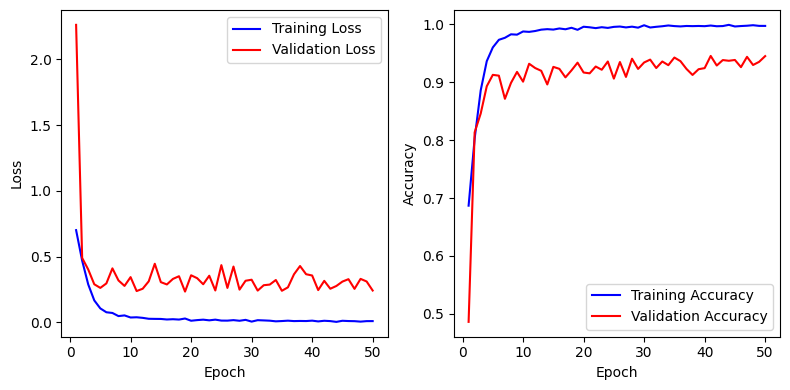

training on fold 2:
Epoch 1/50
1615/1615 [==============================] - 172s 105ms/step - loss: 0.6942 - accuracy: 0.6936 - val_loss: 0.5339 - val_accuracy: 0.7624

Epoch 00001: val_loss improved from inf to 0.53394, saving model to ./models/ResNet1\best_model_2.h5


C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1615/1615 [==============================] - 168s 104ms/step - loss: 0.4433 - accuracy: 0.8150 - val_loss: 0.6440 - val_accuracy: 0.7664

Epoch 00002: val_loss did not improve from 0.53394
Epoch 3/50
1615/1615 [==============================] - 168s 104ms/step - loss: 0.2658 - accuracy: 0.8953 - val_loss: 0.3058 - val_accuracy: 0.8771

Epoch 00003: val_loss improved from 0.53394 to 0.30579, saving model to ./models/ResNet1\best_model_2.h5
Epoch 4/50
1615/1615 [==============================] - 168s 104ms/step - loss: 0.1574 - accuracy: 0.9385 - val_loss: 0.3723 - val_accuracy: 0.8913

Epoch 00004: val_loss did not improve from 0.30579
Epoch 5/50
1615/1615 [==============================] - 168s 104ms/step - loss: 0.1118 - accuracy: 0.9585 - val_loss: 0.4717 - val_accuracy: 0.8576

Epoch 00005: val_loss did not improve from 0.30579
Epoch 6/50
1615/1615 [==============================] - 168s 104ms/step - loss: 0.0675 - accuracy: 0.9762 - val_loss: 0.4068 - val_accuracy: 0.874

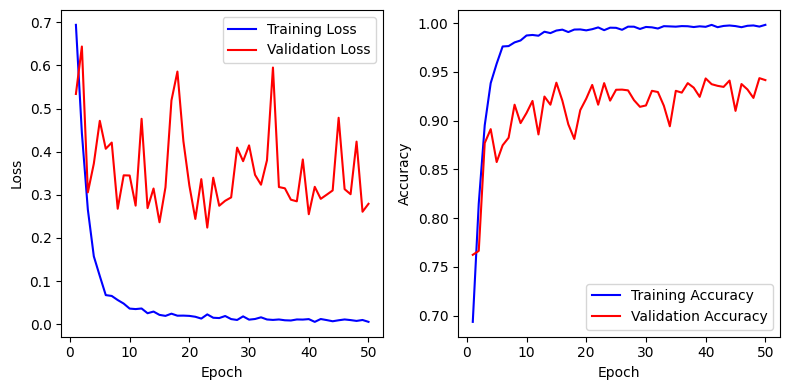

training on fold 3:
Epoch 1/50
1615/1615 [==============================] - 174s 106ms/step - loss: 0.7101 - accuracy: 0.6871 - val_loss: 0.7358 - val_accuracy: 0.7277

Epoch 00001: val_loss improved from inf to 0.73579, saving model to ./models/ResNet1\best_model_3.h5


C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1615/1615 [==============================] - 174s 108ms/step - loss: 0.4324 - accuracy: 0.8203 - val_loss: 0.5847 - val_accuracy: 0.8156

Epoch 00002: val_loss improved from 0.73579 to 0.58474, saving model to ./models/ResNet1\best_model_3.h5
Epoch 3/50
1615/1615 [==============================] - 172s 106ms/step - loss: 0.2546 - accuracy: 0.8991 - val_loss: 0.4297 - val_accuracy: 0.8426

Epoch 00003: val_loss improved from 0.58474 to 0.42965, saving model to ./models/ResNet1\best_model_3.h5
Epoch 4/50
1615/1615 [==============================] - 172s 106ms/step - loss: 0.1497 - accuracy: 0.9435 - val_loss: 0.4188 - val_accuracy: 0.8512

Epoch 00004: val_loss improved from 0.42965 to 0.41877, saving model to ./models/ResNet1\best_model_3.h5
Epoch 5/50
1615/1615 [==============================] - 171s 106ms/step - loss: 0.0989 - accuracy: 0.9631 - val_loss: 0.5976 - val_accuracy: 0.8399

Epoch 00005: val_loss did not improve from 0.41877
Epoch 6/50
1615/1615 [================

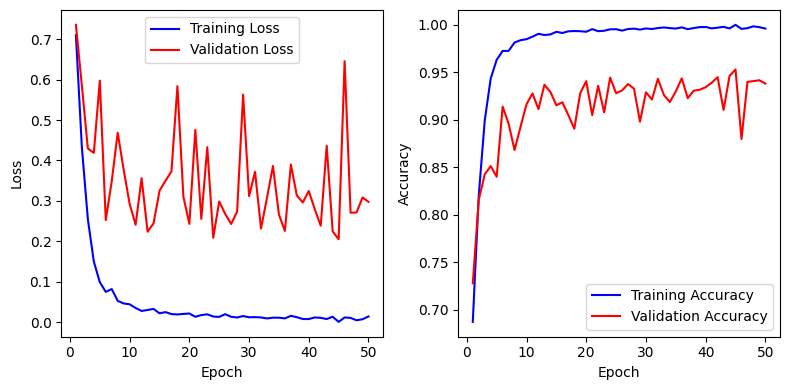

training on fold 4:
Epoch 1/50
1615/1615 [==============================] - 174s 106ms/step - loss: 0.7056 - accuracy: 0.6843 - val_loss: 0.6321 - val_accuracy: 0.7200

Epoch 00001: val_loss improved from inf to 0.63214, saving model to ./models/ResNet1\best_model_4.h5


C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1615/1615 [==============================] - 171s 106ms/step - loss: 0.4317 - accuracy: 0.8208 - val_loss: 0.8180 - val_accuracy: 0.6858

Epoch 00002: val_loss did not improve from 0.63214
Epoch 3/50
1615/1615 [==============================] - 172s 106ms/step - loss: 0.2699 - accuracy: 0.8915 - val_loss: 1.3955 - val_accuracy: 0.7074

Epoch 00003: val_loss did not improve from 0.63214
Epoch 4/50
1615/1615 [==============================] - 172s 106ms/step - loss: 0.1634 - accuracy: 0.9383 - val_loss: 0.3440 - val_accuracy: 0.8825

Epoch 00004: val_loss improved from 0.63214 to 0.34402, saving model to ./models/ResNet1\best_model_4.h5
Epoch 5/50
1615/1615 [==============================] - 171s 106ms/step - loss: 0.1138 - accuracy: 0.9587 - val_loss: 0.5249 - val_accuracy: 0.8376

Epoch 00005: val_loss did not improve from 0.34402
Epoch 6/50
1615/1615 [==============================] - 171s 106ms/step - loss: 0.0735 - accuracy: 0.9738 - val_loss: 0.3669 - val_accuracy: 0.883

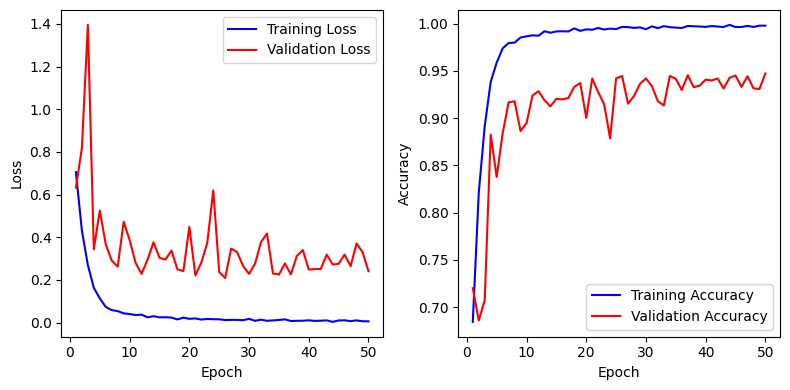

In [8]:
# memory leaking solved by adding gc.collect(), decreasing image size and batch size also helps.
# Following loop works with 32 Gib RAM PC
# set fold with a fixed random seed
kf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=RANDOM_SEED)
val_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
#accuracy_list = []
weighted_f1_list = []
auc_ovr_list = []
auc_ovo_list = []
#precision_list = []
#recall_list = []
fold_id = 0

# 5-fold cross-validation
for train_index_, test_index in  kf.split(images, labels):
    train_images_fold_, test_images_fold = images[train_index_], images[test_index]
    train_labels_fold_, test_labels_fold = labels[train_index_], labels[test_index]
    for train_index, val_index in val_split.split(train_images_fold_, train_labels_fold_):
        train_images_fold, val_images_fold = train_images_fold_[train_index], train_images_fold_[val_index] 
        train_labels_fold, val_labels_fold = train_labels_fold_[train_index], train_labels_fold_[val_index] 
    
    
    # get model
    model = create_model(input_shape=(image_size[0], image_size[1], num_channels), num_classes=3)

    best_epoch = get_checkpoint_for_fold(fold_id)
    
    # train the model
    print(f'training on fold {fold_id}:')
    history = model.fit(train_images_fold, train_labels_fold, 
                        epochs=EPOCH_NUM, 
                        batch_size=BATCH_SIZE,
                        #validation_split = 0.2,
                        validation_data=(val_images_fold, val_labels_fold),
                        callbacks=[best_epoch],
                        verbose=1)
    best_model_weight_dir = model_weights_dir + f'/best_model_{fold_id}.h5'

    if os.path.exists(best_model_weight_dir):
        #best_model = create_model(input_shape=(image_size[0], image_size[1], num_channels), num_classes=3)
        best_model = load_model(best_model_weight_dir)
        f1, auc_ovr, auc_ovo = test_model(model, test_images_fold, test_labels_fold)
        
        # store the values of metrics
        weighted_f1_list.append(f1)
        auc_ovr_list.append(auc_ovr)
        auc_ovo_list.append(auc_ovo)

        #move on for next fold
        fold_id += 1

    # get training history
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    # Get Loss-epoch plot
    num_epochs = len(loss)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), loss, label='Training Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy changes with epoch plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), accuracy, label='Training Accuracy', color='blue')
    plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # releases the memory when there are many models in a loop
    try:
        del model, history, train_images_fold, test_images_fold, train_labels_fold, test_labels_fold
    except Exception as e:
        print(f"fail to release memory")
        print(f"Error message: {e}")
    # finnish a full collection
    gc.collect()
    clear_session()
    

In [9]:
print('Result of 5-fold Cross-validation on Test set data:')
print(f'weighted f1 score :{weighted_f1_list}\n')
print(f'Average of weighted auc OvR in 5 folds: {np.mean(auc_ovr_list)}')
print(f'Variance of weighted auc OvR in 5 folds: {np.var(auc_ovr_list)}')
print(f'Average of weighted auc OvO in 5 folds: {np.mean(auc_ovo_list)}')
print(f'Variance of weighted auc OvO in 5 folds: {np.var(auc_ovo_list)}')
print(f'Average of weighted F1 Score in 5 folds: {np.mean(weighted_f1_list)}')
print(f'Variance of Weighted F1 Score in 5 folds: {np.var(weighted_f1_list)}')

#print(f'Average Precision: { np.mean(precision_list)}')
#print(f'Variance of Precision: {np.var(precision_list)}')

#print(f'Average Recall: {np.mean(recall_list)}')
#print(f'Variance of Recall: {np.var(recall_list)}')

Result of 5-fold Cross-validation on Test set data:
weighted f1 score :[0.9408320268075713, 0.9452540421464445, 0.9476591316172849, 0.9385122583831678, 0.9426929955898254]

Average of weighted auc OvR in 5 folds: 0.993577588962642
Variance of weighted auc OvR in 5 folds: 1.9157865404239796e-07
Average of weighted auc OvO in 5 folds: 0.9927940680722831
Variance of weighted auc OvO in 5 folds: 2.405551162148933e-07
Average of weighted F1 Score in 5 folds: 0.9429900909088588
Variance of Weighted F1 Score in 5 folds: 1.0344381353019934e-05


# Refit the unfrozen model with the best performed weight in 5 folds.


In [11]:
test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in test_split.split(images, labels):
    train_images, test_images = images[train_index], images[test_index] 
    train_labels, test_labels = labels[train_index], labels[test_index] 
best_model_id = weighted_f1_list.index(max(weighted_f1_list))
best_model = load_model(model_weights_dir + f'/best_model_{best_model_id}.h5')
# unfreeze all the layers and do refit
for layer in best_model.layers:
    layer.trainable = True
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
best_model.fit(train_images, train_labels, epochs=100, batch_size=BATCH_SIZE,callbacks=[early_stopping], verbose=1)
test_model(best_model, test_images, test_labels)
best_model.save_weights(model_weights_dir + f'/refit_best_model.h5')#not right, only save weights

Epoch 1/100
2019/2019 [==============================] - 193s 95ms/step - loss: 0.0751 - accuracy: 0.9744
Epoch 2/100
2019/2019 [==============================] - 192s 95ms/step - loss: 0.0223 - accuracy: 0.9932
Epoch 3/100
2019/2019 [==============================] - 189s 94ms/step - loss: 0.0207 - accuracy: 0.9932
Epoch 4/100
2019/2019 [==============================] - 202s 100ms/step - loss: 0.0181 - accuracy: 0.9939
Epoch 5/100
2019/2019 [==============================] - 195s 97ms/step - loss: 0.0194 - accuracy: 0.9935
Epoch 6/100
2019/2019 [==============================] - 191s 95ms/step - loss: 0.0182 - accuracy: 0.9948
Epoch 7/100
2019/2019 [==============================] - 196s 97ms/step - loss: 0.0193 - accuracy: 0.9936
Epoch 8/100
2019/2019 [==============================] - 197s 97ms/step - loss: 0.0114 - accuracy: 0.9960
Epoch 9/100
2019/2019 [==============================] - 199s 99ms/step - loss: 0.0137 - accuracy: 0.9953
Epoch 10/100
2019/2019 [=====================

In [14]:
best_model.save(model_weights_dir + f'/final_best_model.h5')

C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Test results analysis of models.

## Some conclusions
- The blocks above shows that both 3 classes gets balanced performance in these 5 folds of cross-validation.
- Model 0 performances best in validation dataset and also best in test set.
- In the confusion matrix, the off-diagonal values ​​are all small, indicating that the model misclassifies between classes relatively rarely.
## Further study
- The goal of 5-fold cross-validation is to evaluate the performance of pre-trained model MobileNetV3, actually not all the data in training set is used for training in the same time.
- Also, in order to test the generalization ability and robustness of the model, the number of samples in the test set may be increased through data augmentation.

# Sensitive analysis with shuffled labels and shuffled images

## Test with Shuffled Labels
Shuffle the labels of test dataset, use models trained from normal data. 

In [15]:
test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1024)
for train_index, test_index in test_split.split(images, labels):
    train_images, test_images = images[train_index], images[test_index] 
    train_labels, test_labels = labels[train_index], labels[test_index] 
np.random.shuffle(test_labels)
model_x_dir = model_weights_dir + f'/final_best_model.h5'
model_x = load_model(model_x_dir)
test_model(model_x, test_images, test_labels)

Test set performance:
Weighted AUC(OvR): 0.5012597518581386
Weighted AUC(OvO): 0.5017152498501284
Weighted F1 score = 0.3442718667135459
Weighted Precision = 0.3445412466928625, Weighted Recall = 0.3440247678018576, Accuracy = 0.3440247678018576
Confusion matrix:

[[ 643  889  708]
 [ 928 1322 1025]
 [ 712 1035  813]]
Result of classification report:

              precision    recall  f1-score   support

           0       0.28      0.29      0.28      2240
           1       0.41      0.40      0.41      3275
           2       0.32      0.32      0.32      2560

    accuracy                           0.34      8075
   macro avg       0.34      0.34      0.34      8075
weighted avg       0.34      0.34      0.34      8075



(0.3442718667135459, 0.5012597518581386, 0.5017152498501284)

- In all 5 folds, Weighted AUC is close to 0.5, which means that the prediction is a random prediction.
- The 'macro avg' of accuracy is close to 0.33, when the difference of number and performance between classes is not considered.
- Therefore, when shuffle labels, the model rarely works, which means the model concentrate more on the texture and structure of the images.

## Test with shuffle pixels
According to the confusion matrix, the process of classification is destroyed completely, all images are randomly classified into one or two classes.

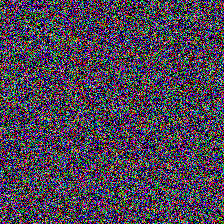

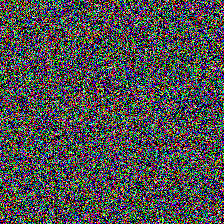

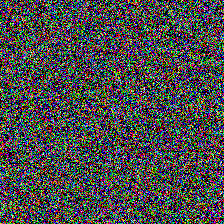

Test set performance:
Weighted AUC(OvR): 0.5003872130328488
Weighted AUC(OvO): 0.5003996077172331
Weighted F1 score = 0.12047980862881164
Weighted Precision = 0.07695041647097164, Weighted Recall = 0.2773993808049536, Accuracy = 0.2773993808049536
Confusion matrix:

[[2240    0    0]
 [3275    0    0]
 [2560    0    0]]
Result of classification report:

              precision    recall  f1-score   support

           0       0.28      1.00      0.43      2240
           1       0.00      0.00      0.00      3275
           2       0.00      0.00      0.00      2560

    accuracy                           0.28      8075
   macro avg       0.09      0.33      0.14      8075
weighted avg       0.08      0.28      0.12      8075



C:\DevTools\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevTools\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevTools\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DevTools\Anaconda3\envs\tf\lib\site-packages\sklea

(0.12047980862881164, 0.5003872130328488, 0.5003996077172331)

In [16]:
from IPython.display import display, Image
import cv2
test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2048)
for train_index, test_index in test_split.split(images, labels):
    train_images, test_images = images[train_index], images[test_index] 
    train_labels, test_labels = labels[train_index], labels[test_index] 

import numpy as np

num_images, height, width, num_channels = test_images.shape

random_indices = np.arange(height * width)

for i in range(num_images):
    for j in range(num_channels):
        np.random.shuffle(random_indices)
        test_images[i, :, :, j] = test_images[i, :, :, j].reshape(-1)[random_indices].reshape((height, width))

for i in range(3):
    pred = test_images[i]
    # Convert image data to uint8
    pred = np.array(pred, np.uint8)
    # Display the image after pixel shuffled
    display(Image(data=cv2.imencode('.png', pred)[1].tobytes()))

model_x_dir = model_weights_dir + f'/final_best_model.h5'
model_x = load_model(model_x_dir)
test_model(model_x, test_images, test_labels)

#print(test_labels)
#for i in range(0,5): 
#    model_id = i
#    print(f'model{model_id} selected:')
#    model_x_dir =model_weights_dir + f'/best_model_{model_id}.h5'
#    model_x = load_model(model_x_dir)
#    test_shuffle_model(model_x, test_images, test_labels)

# Train with shuffled labels

In [ ]:
import os,gc,time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.backend import clear_session

def load_shuffled_label(directory):
    '''
    modified from the function above
    '''
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        print(f'loading images from {class_dir}')
        for filename in tqdm(os.listdir(class_dir)):
            image_path = os.path.join(class_dir, filename)
            try:
                image = cv2.imread(image_path)
                #image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(class_names.index(class_name))
            except Exception as e:
                print(f"Error loading image: {image_path}")
                print(f"Error message: {e}")
    shuffled_idx = np.arange(len(labels))
    np.random.shuffle(shuffled_idx)
    shuffled_labels = np.array(labels)[shuffled_idx]

    return np.array(images), shuffled_labels

def load_shuffled_pixel(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        print(f'loading images from {class_dir}')
        for filename in tqdm(os.listdir(class_dir)):
            image_path = os.path.join(class_dir, filename)
            try:
                image = cv2.imread(image_path)
                for channel in range(image.shape[2]):
                    channel_data = image[:, :, channel]
                    flat_channel_data = channel_data.ravel()#flat the 2-dimension array into 1-dimension
                    np.random.shuffle(flat_channel_data)
                    image[:, :, channel] = flat_channel_data.reshape(channel_data.shape) # reshape the picture
                images.append(image)
                labels.append(class_names.index(class_name))
            except Exception as e:
                print(f"Error loading image: {image_path}")
                print(f"Error message: {e}")
    return np.array(images), np.array(labels)
    
def train_shuffle_model(model, train_images, train_labels, epoch_num, batch_size):
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_images, train_labels, test_size=0.2, random_state=2023)
    history = model.fit(train_images, train_labels, 
                        epochs=epoch_num, 
                        batch_size=batch_size,
                        validation_data=(val_images, val_labels),
                        #callbacks=[best_epoch],
                        verbose=2)
        # get predicitons of validation set 
    val_probabilities = model.predict(val_images)
    val_predictions = np.argmax(val_probabilities, axis=1)
    # get training history
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    # Get Loss-epoch plot
    num_epochs = len(loss)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), loss, label='Training Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy changes with epoch
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), accuracy, label='Training Accuracy', color='blue')
    plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def test_shuffle_model(model, test_images, test_labels):
    # use data in test set to make predictions
    test_probabilities = model.predict(test_images)
    test_predictions = np.argmax(test_probabilities, axis=1)

    # calculate metrics
    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    confusion_mat = confusion_matrix(test_labels, test_predictions)
    weighted_auc = roc_auc_score(test_labels, test_probabilities, average='weighted',multi_class='ovr')
    print(f'Test set performance:')
    print("Weighted AUC:", weighted_auc)
    print(f'Accuracy = {accuracy}, Weighted F1 score = {f1}')
    print(f'Weighted Precision = {precision}, Weighted Recall = {recall}')
    print('Confusion matrix:\n')
    print(confusion_mat)

    # get the result of classification report
    report = classification_report(test_labels, test_predictions)
    print(f'Model {model_id} - result of classification report:\n')
    print(report)